In [391]:
import numpy as np
import matplotlib.pyplot as plt
import math

from collections import namedtuple

from scipy.linalg import kron, eigh
from scipy.sparse.linalg import expm_multiply
from scipy.sparse import diags, eye, csr_matrix
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq

from mpl_toolkits.mplot3d import Axes3D
from skspatial.objects import Sphere
from matplotlib import cm


In [400]:
def Dicke_eqsmot(t, mxp, wz, wc, lam, N):
    m = mxp[:-2]
    xp = mxp[-2:]
        
    Bext = np.array([0, 0, wz])
    Brms = np.array([2 * lam / np.sqrt(N), 0, 0])
    Beff = Bext + Brms*xp[0]
    dm = -np.cross(m, Beff) 

    dxp = np.empty(xp.shape)
    dxp[0] = -wc*xp[1]
    dxp[1] = wc*xp[0] + N*np.dot(Brms, m)
    return np.append(dm, dxp)

def Dicke_explicit_eqsmot(t, mxp, wz, wc, lam, N):
    dmxp = np.empty(mxp.shape)
    dmxp[0] = -wz*mxp[1]
    dmxp[1] = wz*mxp[0] - 2*lam/np.sqrt(N)*mxp[3]*mxp[2]
    dmxp[2] = 2*lam/np.sqrt(N)*mxp[3]*mxp[1]
    dmxp[3] = -wc*mxp[4]
    dmxp[4] = wc*mxp[3] + N*2*lam/np.sqrt(N)*mxp[0]
    
    return dmxp

def Dicke_explicit_cavdis_eqsmot(t, mxp, wz, wc, lam, kappa, N):
    dmxp = np.empty(mxp.shape)
    dmxp[0] = -wz*mxp[1]
    dmxp[1] = wz*mxp[0] - 2*lam/np.sqrt(N)*mxp[3]*mxp[2]
    dmxp[2] = 2*lam/np.sqrt(N)*mxp[3]*mxp[1]
    dmxp[3] = -wc*mxp[4] - kappa*mxp[3]
    dmxp[4] = wc*mxp[3] + N*2*lam/np.sqrt(N)*mxp[0] - kappa*mxp[4]
    
    return dmxp

def Dicke_P2_cavdis_eqsmot(t, mxp, wz, wc, lam, kappa, N):
    dmxp = np.empty(mxp.shape)
    dmxp[0] = -wz*mxp[1]
    dmxp[1] = wz*mxp[0] - 2*lam/np.sqrt(N)*mxp[3]*mxp[2] - 4*lam**2/wc*mxp[0]*mxp[2]
    dmxp[2] = 2*lam/np.sqrt(N)*mxp[3]*mxp[1] + 4*lam**2/wc*mxp[0]*mxp[1]
    dmxp[3] = -wc*mxp[4] - kappa*mxp[3]
    dmxp[4] = wc*mxp[3] + N*2*lam/np.sqrt(N)*mxp[0] - kappa*mxp[4]
    
    return dmxp

def LMG_eqsmot(t, m, wz, wc, lam, N):
    dm = np.empty(m.shape)
    dm[0] = -wz*m[1]
    dm[1] = wz*m[0] + 4*lam**2/wc*m[0]*m[2]
    dm[2] = -4*lam**2/wc*m[0]*m[1]
    
    return dm 

def spin_operators(S, *, to_dense_array=False, format=None, dtype=np.float_):
    Sz = diags([m for m in np.arange(-S, S + 1)], format=format, dtype=dtype)
    Sp = diags([math.sqrt(S * (S + 1) - m * (m + 1)) for m in np.arange(-S, S)],
               offsets=-1,
               format=format,
               dtype=dtype
               )
    Sm = Sp.T
    Seye = eye(2 * S + 1, format=format, dtype=dtype)

    Spin_operators = namedtuple('Spin_operators', 'Sz Sp Sm Seye')
    ops = Spin_operators(Sz, Sp, Sm, Seye)
    if to_dense_array:
        ops = Spin_operators(*[o.toarray() for o in ops])

    return ops


def boson_operators(N_photons_cutoff, *, to_dense_array=False, format=None, dtype=np.float_):
    a = diags([math.sqrt(n) for n in range(1, N_photons_cutoff + 1)],
              offsets=1,
              format=format,
              dtype=dtype
              )
    ad = a.T
    beye = eye(N_photons_cutoff + 1, format=format, dtype=dtype)

    Boson_operators = namedtuple('Boson_operators', 'a ad beye')
    ops = Boson_operators(a, ad, beye)
    if to_dense_array:
        ops = Boson_operators(*[o.toarray() for o in ops])

    return ops


def dicke(ws, wc, lam, S, N_photons_cutoff):
    g = lam / np.sqrt(2*S)
    Sz, Sp, Sm, Seye = spin_operators(S, to_dense_array=True)
    Sx = 0.5 * (Sp + Sm)
    a, ad, beye = boson_operators(N_photons_cutoff, to_dense_array=True)

    H = ws * kron(Sz, beye) + wc * kron(Seye, ad @ a) + 2 * g * kron(Sx, a + ad)
    return H

def polaritons(wz, wc, lam):
    def para(wz, wc, lam):
        innerroot = np.sqrt(wz**4 + wc**4 - 2*wz**2*wc**2 + 16*lam**2*wz*wc)
        return np.sqrt(0.5 * (wz**2 + wc**2 - innerroot)), np.sqrt(0.5 * (wz**2 + wc**2 + innerroot))
    
    def ferro(wz, wc, lam):
        mu = wz * wc / (4 * lam**2)
        g = lam * mu * np.sqrt(2 / (1 + mu))
        wztilde = wz * (1 + mu) / (2 * mu)
        eps = wz * (1 - mu) * (3 + mu) / (8 * mu * (1 + mu))
        
        innerroot = np.sqrt(wztilde**4 + wc**4 - 2*wztilde**2*wc**2 + 16*g**2*wztilde*wc + 4*(eps**2*wztilde**2 + eps*wztilde**3 - wc**2*eps*wztilde))
        return np.sqrt(0.5 * (wztilde**2 + wc**2 + 2*eps*wztilde - innerroot)), np.sqrt(0.5 * (wztilde**2 + wc**2 + 2*eps*wztilde + innerroot))
    
    if 4 * lam**2 < wz * wc:
        # paramagnetic phase
        return para(wz, wc, lam)
    else:
        # ferromagnetic phase
        return ferro(wz, wc, lam)

def fft_wrapper(time, timeseries, slice_=None):
    if slice_:
        time = time[slice_]
        timeseries = timeseries[slice_]
        
    ws = fftfreq(len(time), time[1] - time[0])
    amps = np.abs(fft(timeseries))
    
    return ws[:middle(ws)], amps[:middle(ws)]
    #return ws, amps

def middle(seq):
    return len(seq) // 2

def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    
def Peven(S, n_cutoff):
    size = int((2*S + 1) * (n_cutoff + 1))
    Peven = np.zeros((size, size))
    for i, mz in enumerate(np.arange(-S, S + 1)):
        for n in np.arange(n_cutoff + 1):
            if (mz + S + n) % 2 == 0:
                Peven += kron(Pmz(i, S), Pn(n, n_cutoff))
                
    return Peven

def Pmz(i, S):
    diag = np.zeros(int(2 * S + 1))
    diag[i] = 1
    return np.diag(diag)

def Pn(n, n_cutoff):
    diag = np.zeros(n_cutoff + 1)
    diag[n] = 1
    return np.diag(diag)

# Tests of convergence of exact diagonalization

In [5]:

wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
lam = 0.5 * lamc
N_photons_cutoff = 100

Ns = np.arange(10, 300, 20)
mxs_old = 100
for N in Ns:
    H = dicke(wz, wc, lam, N/2, N_photons_cutoff)
    Sz, Sp, Sm, Seye = spin_operators(N/2, to_dense_array=True)
    Sx = 0.5 * (Sp + Sm)
    a, ad, beye = boson_operators(N_photons_cutoff, to_dense_array=True)
    Sx_full = kron(Sx, beye)
    vals, vects = eigh(Sx_full)
    phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mx

    mxs_exact = []
    t = 10
    phi = expm_multiply(-1j * H * t, phi0)
    mxs = 2 * np.vdot(phi, np.dot(Sx_full, phi)) / N
    mxs = mxs.real
    
    var = np.abs(mxs - mxs_old)
    print(N, mxs, mxs_old, var)
    if var < 1e-3:
        print('Converged')
        break
    mxs_old = np.copy(mxs)


10 -0.2790534487879948 100 100.27905344878799
30 -0.25257366924391855 -0.2790534487879948 0.026479779544076265
50 -0.01618358834948927 -0.25257366924391855 0.23639008089442928
70 0.10029608592330204 -0.01618358834948927 0.11647967427279131
90 0.07217521033755489 0.10029608592330204 0.02812087558574715
110 0.07304846420860543 0.07217521033755489 0.0008732538710505416
Converged


In [327]:

wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
lam = 0.5 * lamc
N_photons_cutoffs = np.arange(10, 150, 10)

N = 10
mxs_old = 100
for N_photons_cutoff in N_photons_cutoffs:
    H = dicke(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N/2, N_photons_cutoff)
    Sz, Sp, Sm, Seye = spin_operators(N/2, to_dense_array=True)
    Sx = 0.5 * (Sp + Sm)
    a, ad, beye = boson_operators(N_photons_cutoff, to_dense_array=True)
    Sx_full = kron(Sx, beye)
    vals, vects = eigh(Sx_full)
    phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mx

    mxs_exact = []
    t = 2
    phi = expm_multiply(-1j * H * t, phi0)
    mxs = 2 * np.vdot(phi, np.dot(Sx_full, phi)) / N
    mxs = mxs.real
    
    var = np.abs(mxs - mxs_old)
    print(N_photons_cutoff, mxs, mxs_old, var)
    if var < 1e-3:
        print('Converged')
        break
    mxs_old = np.copy(mxs)


10 -0.056391658818835504 100 100.05639165881884
20 0.06618678504993968 -0.056391658818835504 0.12257844386877517
30 0.1739031983394163 0.06618678504993968 0.10771641328947663
40 0.0948068646574991 0.1739031983394163 0.07909633368191721
50 0.06747516520537629 0.0948068646574991 0.027331699452122812
60 0.23277673577838504 0.06747516520537629 0.16530157057300876
70 0.3524668541197804 0.23277673577838504 0.11969011834139537
80 0.17670855869592145 0.3524668541197804 0.17575829542385896
90 0.143694912756379 0.17670855869592145 0.03301364593954245
100 0.04415311254532582 0.143694912756379 0.09954180021105317
110 0.1651692254775915 0.04415311254532582 0.12101611293226568
120 0.05575454075334738 0.1651692254775915 0.10941468472424412
130 -0.09894255464335058 0.05575454075334738 0.15469709539669796
140 0.12264629695217802 -0.09894255464335058 0.2215888515955286


In [6]:
N_photons_cutoff = 100
Ns = [10, 30, 50, 70, 100]

for N in Ns:
    data = np.load(f'data/mx_exact_resonance_0.5_{N}_{N_photons_cutoff}.npz')
    plt.plot(data['t'], data['mxs'], label=N)

plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/mx_exact_resonance_0.5_10_100.npz'

In [ ]:
wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
lam = 0.5 * lamc

Ns = np.arange(10, 200, 10)
N_cutoffs = np.arange(50, 200, 10)

mxs_old = 100
for N_cutoff in N_cutoffs:
    for N in Ns:
        H = dicke(wz, wc, lam, N/2, N_photons_cutoff)
        Sz, Sp, Sm, Seye = spin_operators(N/2, to_dense_array=True)
        Sx = 0.5 * (Sp + Sm)
        a, ad, beye = boson_operators(N_photons_cutoff, to_dense_array=True)
        Sx_full = kron(Sx, beye)
        vals, vects = eigh(Sx_full)
        phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mx
        phi = expm_multiply(-1j * H * t, phi0)
        mxs_new = 2 * np.vdot(phi, np.dot(Sx_full, phi)) / N
        
        if np.abs(mxs_new - mxs_old) < 1e-3:
            mxs_old = np.copy(mxs_new)
            
def sweep_range(range_, f, *, f_args=None, rtol=1e-3):
    old_value = f(range_[0])
    for point in range_[1]:
        new_value = f(point)
        if np.abs(new_value - old_value) < rtol*old_value:
            break
    return np.where(range_ == point)[0][0]

def search_2D(range1, range2, f, *, f_args=None, rtol=1e-3):
    pass

# Saving exact diagonalization simulations

In [348]:
N = 120
N_photons_cutoff = 50
tmax = 1
ts = np.linspace(0, tmax, 10)

wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
lam = 0.5 * lamc

H = dicke(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N/2, N_photons_cutoff)
Sz, Sp, Sm, Seye = spin_operators(N/2, to_dense_array=True)
Sx = 0.5 * (Sp + Sm)
a, ad, beye = boson_operators(N_photons_cutoff, to_dense_array=True)
Sx_full = kron(Sx, beye)
vals, vects = eigh(Sx_full)
phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mx

mxs = []
for t in ts:
    phi = expm_multiply(-1j * H * t, phi0)
    mxs.append(2 * np.vdot(phi, np.dot(Sx_full, phi)) / N)
mxs = np.array(mxs)

np.savez(f'data/mx_exact_resonance_{lam/lamc}_{N}_{N_photons_cutoff}_{tmax}', ts=ts, mxs=mxs)

# Comparison of evolution of different models

In [323]:
plt.rcParams['figure.figsize'] = (10, 3)

N = 100
tmax = 200

wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
lam = 0.5 * lamc

my0 = 0.01
#m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
m0 = np.array([1, 0, 0, 0, 0]) # m0 is the state with maximum mx
#m0 = np.array([0, 0, 1, 0, 0]) # m0 is the state with maximum mz

t_eval = np.linspace(0, tmax, 500000)
max_step = 0.01
sol = solve_ivp(Dicke_eqsmot, (0, tmax), m0, method='RK45', args=(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N), t_eval=t_eval, max_step=max_step)
idx = 1
ws, amps = fft_wrapper(sol.t, sol.y[idx], slice(middle(sol.t), -1))

sol_ex = solve_ivp(Dicke_explicit_eqsmot, (0, tmax), m0, method='RK45', args=(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N), t_eval=t_eval, max_step=max_step)
ws_ex, amps_ex = fft_wrapper(sol_ex.t, sol_ex.y[idx], slice(middle(sol_ex.t), -1))

sol_p2 = solve_ivp(Dicke_P2_eqsmot, (0, tmax), m0, method='RK45', args=(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N), t_eval=t_eval, max_step=max_step)
ws_p2, amps_p2 = fft_wrapper(sol_p2.t, sol_p2.y[idx], slice(middle(sol_p2.t), -1))

sol_lmg = solve_ivp(LMG_eqsmot, (0, tmax), m0, method='RK45', args=(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N), t_eval=t_eval, max_step=max_step)
ws_lmg, amps_lmg = fft_wrapper(sol_lmg.t, sol_lmg.y[idx], slice(middle(sol_lmg.t), -1))

/Users/jroman/miniconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


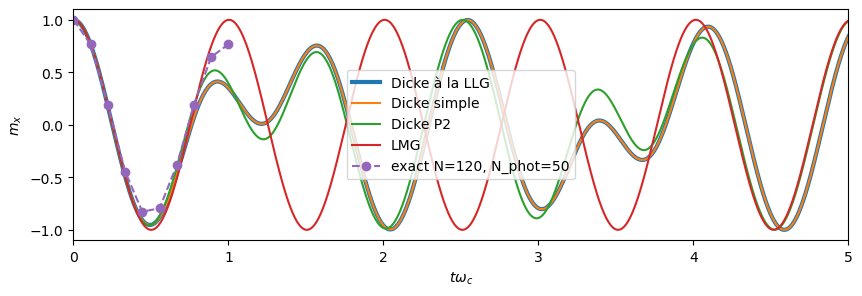

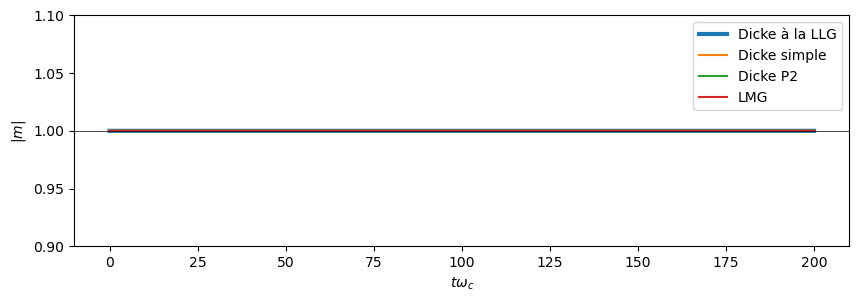

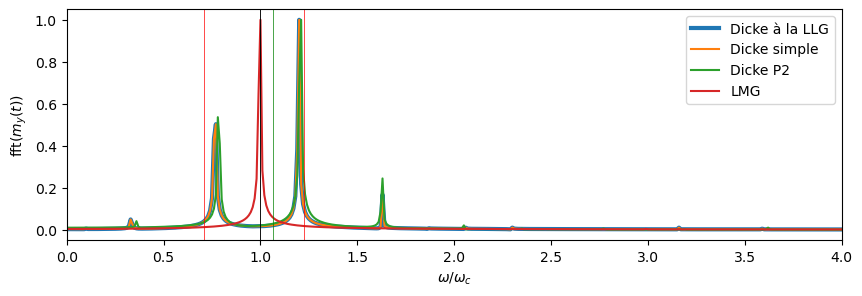

In [349]:
idx = 0
labels = {0: r'$m_x$',
          1: r'$m_y$',
          2: r'$m_z$',
          3: r'$x = a + a^\dagger$',
          4: r'$p = i (a - a^\dagger)$'}
plt.plot(sol.t, sol.y[idx], label='Dicke à la LLG', lw=3)
plt.plot(sol_ex.t, sol_ex.y[idx], label='Dicke simple')
plt.plot(sol_p2.t, sol_p2.y[idx], label='Dicke P2')
plt.plot(sol_lmg.t, sol_lmg.y[idx], label='LMG')
if idx == 0:
    data = np.load('data/mx_exact_resonance_0.5_120_50_1.npz')
    ts = data['ts']
    mxs = data['mxs']
    plt.plot(ts, mxs, label=f'exact N={N}, N_phot={N_photons_cutoff}', marker='o', ls='dashed')
#plt.plot(t_exact, mxs_exact, label='Dicke exact', lw=0, marker='o')
plt.ylabel(labels[idx])
plt.xlabel(r'$t \omega_c$')
start = 0
window = 5
plt.xlim(start, start+window)
plt.legend()
plt.show()

plt.plot(sol.t, np.linalg.norm(sol.y[:3], axis=0), label='Dicke à la LLG', lw=3)
plt.plot(sol_ex.t, np.linalg.norm(sol_ex.y[:3], axis=0), label='Dicke simple')
plt.plot(sol_p2.t, np.linalg.norm(sol_p2.y[:3], axis=0), label='Dicke P2')
plt.plot(sol_lmg.t, np.linalg.norm(sol_lmg.y[:3], axis=0), label='LMG')
plt.ylabel(r'$|m|$')
plt.xlabel(r'$t \omega_c$')
plt.axhline(1.0, c='k', lw=0.5)
plt.ylim(0.9, 1.1)
plt.legend()
plt.show()

plt.plot(ws, amps / np.amax(amps), label='Dicke à la LLG', lw=3)
plt.plot(ws_ex, amps_ex / np.amax(amps_ex), label='Dicke simple')
plt.plot(ws_p2, amps_p2 / np.amax(amps_p2), label='Dicke P2')
plt.plot(ws_lmg, amps_lmg / np.amax(amps_lmg), label='LMG')
#plt.xlim(0.8*min(wz, wc), 1.2*max(wz, wc))
plt.xlim(0, 4)
#plt.ylim(0, 50)
plt.axvline(wc, c='k',lw=0.5)
plt.axvline(wz, c='k',lw=0.5)
plt.axvline(wz + lam**2 / wc, c='g',lw=0.5)
# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='r', lw=0.5)
# -----------------------------------------
plt.ylabel(r'fft($m_y(t)$)')
plt.xlabel(r'$\omega / \omega_c$')
plt.legend()
plt.show()

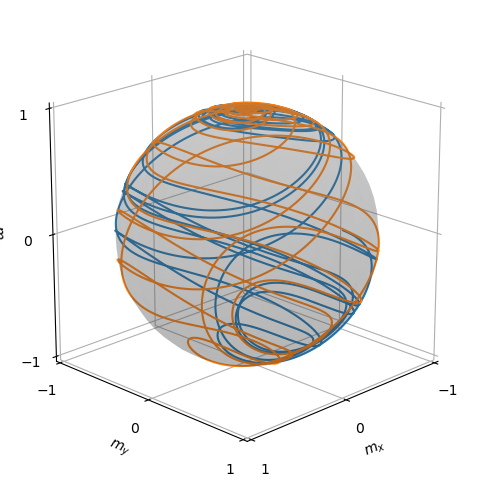

In [266]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

sphere = Sphere([0, 0, 0], 1)
sphere.plot_3d(ax, alpha=0.2, color='gray')
end = 50000
ax.plot(sol.y[0][:end], sol.y[1][:end], sol.y[2][:end])
ax.plot(sol_p2.y[0][:end], sol_p2.y[1][:end], sol_p2.y[2][:end])

ax.set_xlabel(r'$m_x$')
ax.set_ylabel(r'$m_y$')
ax.set_zlabel(r'$m_z$')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])

ax.view_init(elev=20., azim=45, roll=0)

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_box_aspect([1,1,1])
set_axes_equal(ax)
plt.show()

# Evolution of frequency peaks with increasing damping

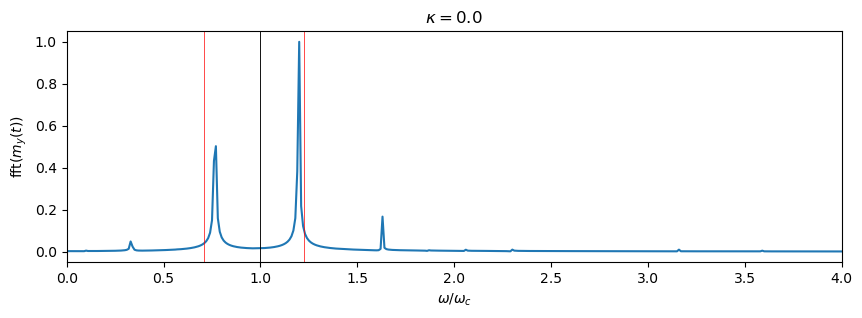

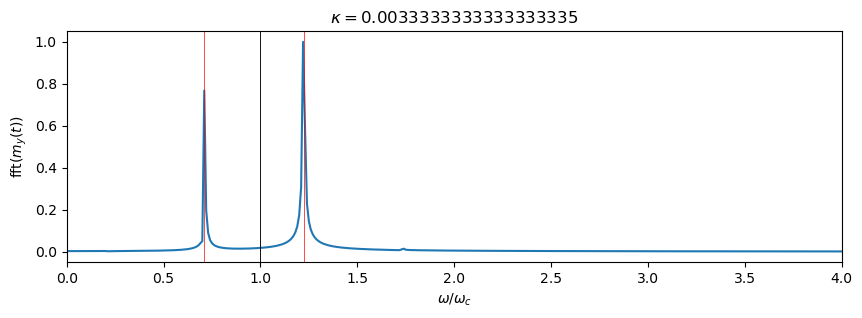

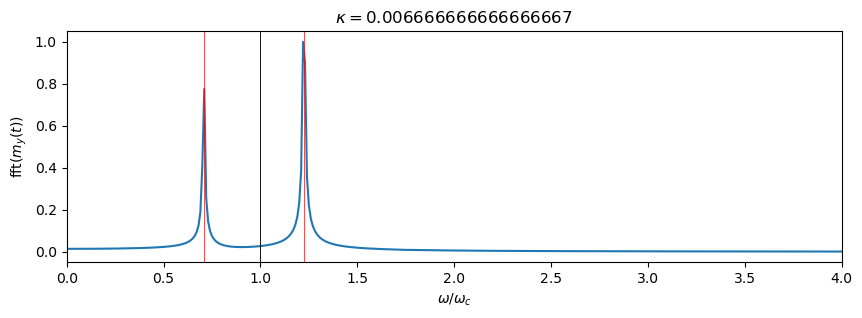

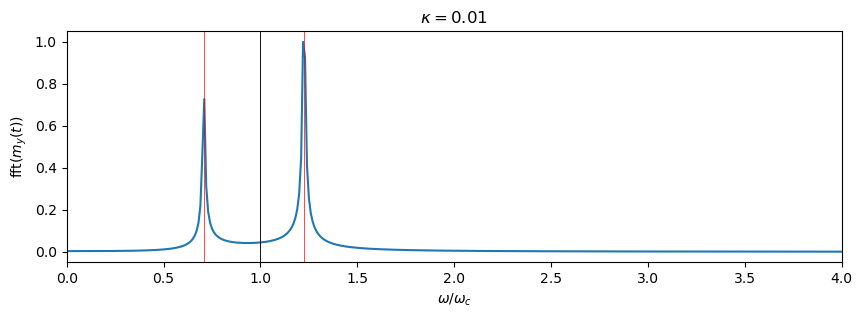

In [184]:
plt.rcParams['figure.figsize'] = (10, 3)

N = 110
tmax = 200

wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
lam = 0.5 * lamc

kappas = wc * np.linspace(0, 0.01, 4)

for kappa in kappas:
    my0 = 0.01
    #m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
    m0 = np.array([1, 0, 0, 0, 0]) # m0 is the state with maximum mx

    t_eval = np.linspace(0, tmax, 500000)
    max_step = 0.01
    sol = solve_ivp(Dicke_explicit_cavdis_eqsmot, (0, tmax), m0, method='RK45', args=(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, 2*np.pi * kappa, N), t_eval=t_eval, max_step=max_step)
    idx = 1
    ws, amps = fft_wrapper(sol.t, sol.y[idx], slice(middle(sol.t), -1))
    
    plt.plot(ws, amps / np.amax(amps), label='Dicke simple')
    #plt.xlim(0.5*min(wz, wc), 1.5*max(wz, wc))
    plt.xlim(0, 4)
    #plt.ylim(0, 0.3)
    plt.axvline(wc, c='k',lw=0.5)
    plt.axvline(wz, c='k',lw=0.5)
    # AQUI SE CALCULAN Y PINTAN LOS POLARITONES
    pm, pp = polaritons(wz, wc, lam)
    for p in (pm, pp):
        plt.axvline(p, c='r', lw=0.5)
    # -----------------------------------------
    #plt.legend()
    plt.ylabel(r'fft($m_y(t)$)')
    plt.xlabel(r'$\omega / \omega_c$')
    plt.title(rf'$\kappa = {kappa}$')
    plt.show()

# Comparison with stitely2020nonlinear

In [313]:
plt.rcParams['figure.figsize'] = (10, 3)

N = 100
tmax = 100

wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
#lam = 0.5 * lamc
lam = 1.0
kappa = 1 * wc

my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
#m0 = np.array([1, 0, 0, 0, 0]) # m0 is the state with maximum mx
#m0 = np.array([0, 0, 1, 0, 0]) # m0 is the state with maximum mz

t_eval = np.linspace(0, tmax, 500000)
max_step = 0.001

idx = 1

sol_ex = solve_ivp(Dicke_explicit_cavdis_eqsmot, (0, tmax), m0, method='RK45', args=(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, 2*np.pi * kappa,  N), t_eval=t_eval, max_step=max_step)
ws_ex, amps_ex = fft_wrapper(sol_ex.t, sol_ex.y[idx], slice(middle(sol_ex.t), -1))

sol_p2 = solve_ivp(Dicke_P2_cavdis_eqsmot, (0, tmax), m0, method='RK45', args=(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, 2*np.pi * kappa, N), t_eval=t_eval, max_step=max_step)
ws_p2, amps_p2 = fft_wrapper(sol_p2.t, sol_p2.y[idx], slice(middle(sol_p2.t), -1))

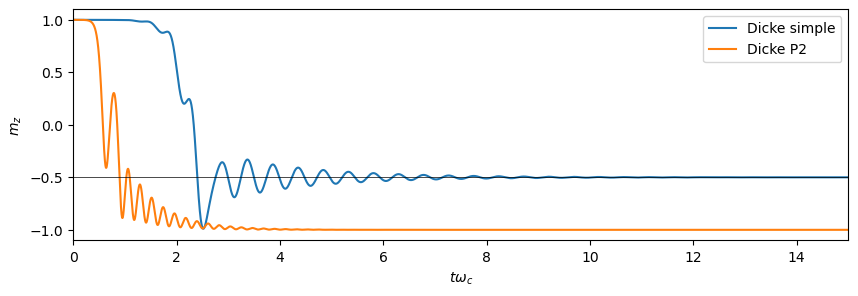

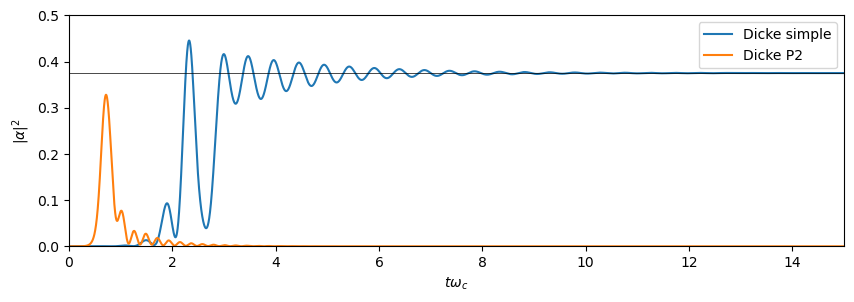

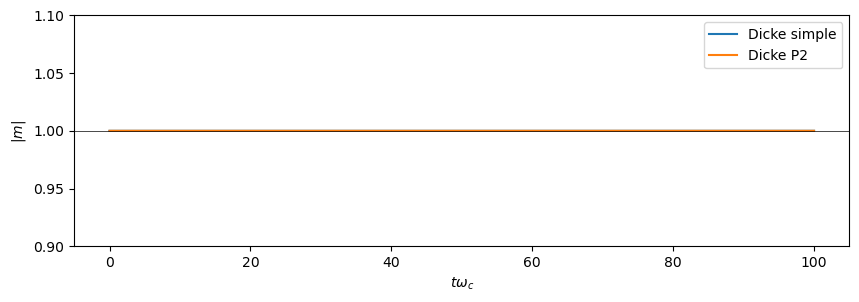

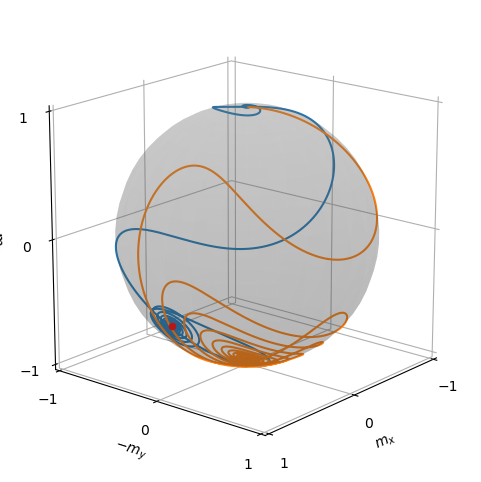

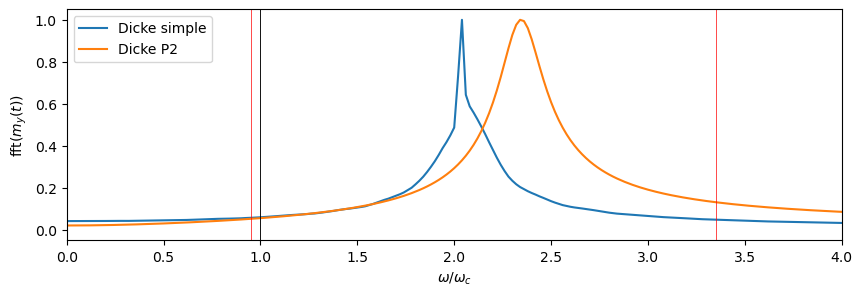

In [318]:
idx = 2
labels = {0: r'$m_x$',
          1: r'$m_y$',
          2: r'$m_z$',
          3: r'$x = a + a^\dagger$',
          4: r'$p = i (a - a^\dagger)$'}
plt.plot(sol_ex.t, sol_ex.y[idx], label='Dicke simple')
plt.plot(sol_p2.t, sol_p2.y[idx], label='Dicke P2')
plt.axhline(-lamc/lam, c='k', lw=0.5)
plt.ylabel(labels[idx])
plt.xlabel(r'$t \omega_c$')
start = 0
window = 15
plt.xlim(start, start+window)
plt.legend()
plt.show()

plt.plot(sol_ex.t, 0.25 * (sol_ex.y[3]**2 + sol_ex.y[4]**2) / N, label='Dicke simple')
plt.plot(sol_p2.t, 0.25 * (sol_p2.y[3]**2 + sol_p2.y[4]**2) / N, label='Dicke P2')
plt.axhline(0.5 * (1 - (lamc/lam)**2), c='k', lw=0.5)
plt.ylabel(r'$|\alpha|^2$')
plt.xlabel(r'$t \omega_c$')
start = 0
window = 15
plt.xlim(start, start+window)
plt.ylim(0.0, 0.5)
plt.legend()
plt.show()

plt.plot(sol_ex.t, np.linalg.norm(sol_ex.y[:3], axis=0), label='Dicke simple')
plt.plot(sol_p2.t, np.linalg.norm(sol_p2.y[:3], axis=0), label='Dicke P2')
plt.ylabel(r'$|m|$')
plt.xlabel(r'$t \omega_c$')
plt.axhline(1.0, c='k', lw=0.5)
plt.ylim(0.9, 1.1)
plt.legend()
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

sphere = Sphere([0, 0, 0], 1)
sphere.plot_3d(ax, alpha=0.2, color='gray')
end = -1
ax.plot(sol_ex.y[0][:end], -sol_ex.y[1][:end], sol_ex.y[2][:end])
ax.scatter(np.sqrt(1 - (lamc/lam)**2), 0, -lamc/lam, c='r')
ax.plot(sol_p2.y[0][:end], sol_p2.y[1][:end], sol_p2.y[2][:end])

ax.set_xlabel(r'$m_x$')
ax.set_ylabel(r'$-m_y$')
ax.set_zlabel(r'$m_z$')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])

ax.view_init(elev=17.5, azim=40, roll=0)

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_box_aspect([1,1,1])
set_axes_equal(ax)
plt.show()

plt.plot(ws_ex, amps_ex / np.amax(amps_ex), label='Dicke simple')
plt.plot(ws_p2, amps_p2 / np.amax(amps_p2), label='Dicke P2')
#plt.xlim(0.8*min(wz, wc), 1.2*max(wz, wc))
plt.xlim(0, 4)
#plt.ylim(0, 50)
plt.axvline(wc, c='k',lw=0.5)
plt.axvline(wz, c='k',lw=0.5)
#plt.axvline(wz + lam**2 / wc, c='g',lw=0.5)
# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='r', lw=0.5)
# -----------------------------------------
plt.ylabel(r'fft($m_y(t)$)')
plt.xlabel(r'$\omega / \omega_c$')
plt.legend()
plt.show()

# Spectrum and level statistics

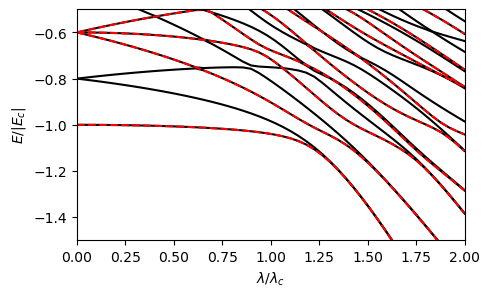

In [423]:
plt.rcParams['figure.figsize'] = (5, 3)

N = 10
N_photons_cutoff = 10

wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
lams = lamc * np.linspace(0, 2, 50)

P = Peven(N/2, N_photons_cutoff)

energies = []
for lam in lams:
    H = dicke(wz, wc, lam, N/2, N_photons_cutoff)
    #H = P @ H @ P
    vals = eigh(H, eigvals_only=True)
    
    energies.append(vals / (N/2))

plt.plot(lams / lamc, energies, c='k')

energies = []
for lam in lams:
    H = dicke(wz, wc, lam, N/2, N_photons_cutoff)
    H = P @ H @ P
    vals = eigh(H, eigvals_only=True)
    
    energies.append(vals / (N/2))

plt.plot(lams / lamc, energies, c='r', ls='dashed')

plt.ylabel(r'$E/|E_c|$')
plt.xlabel(r'$\lambda/\lambda_c$')
plt.xlim(0, 2)
plt.ylim(-1.5, -0.5)
plt.show()

## Level statistics

In [473]:
plt.rcParams['figure.figsize'] = (5, 3)

N = 20
N_photons_cutoff = 50

wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
lam = 0.2

P = Peven(N/2, N_photons_cutoff)

H = dicke(wz, wc, lam, N/2, N_photons_cutoff)
Heven = P @ H @ P
vals = eigh(Heven, eigvals_only=True)

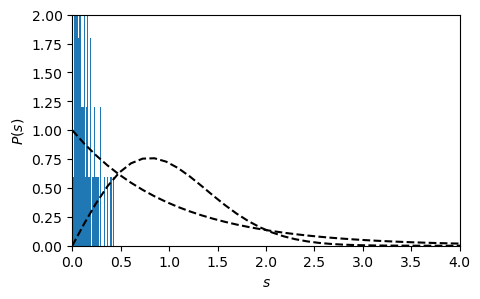

In [474]:

start = 0
level_spacings = (vals[start+1:] - vals[start:-1]) #/ np.abs(vals[:-1])
#level_spacings = level_spacings[level_spacings < 4]

plt.hist(level_spacings, bins=1000,  density=True)
s = np.linspace(0, 12, 100)
plt.plot(s, np.exp(-s), c='k', ls='dashed')
plt.plot(s, np.pi*s/2 * np.exp(-np.pi*s**2/4), c='k', ls='dashed')
plt.ylabel(r'$P(s)$')
plt.xlabel(r'$s$')
plt.xlim(0, 4)
plt.ylim(0, 2)
#plt.ylim(-1.5, -0.5)
plt.show()